In [1]:
import json

file_path = '../data/squad/train-v2.0.json'
with open(file_path, 'r') as file:
    squad_data = json.load(file)

## 1. Dataset Composition
The dataset is organized hierarchically, consisting of:
- **Article**
    - **Title**: The name of the Wikipedia article from which paragraphs are extracted.
    - **Paragraphs**: A list of paragraphs from the article, each containing:
        - **Context**: The actual text of the paragraph.
        - **QAs**: A collection of question-answer pairs related to the context, including:
            - **Question**: A question formulated based on the context.
            - **ID**: A unique identifier for each question, allowing for easy reference.
            - **Answers**: (For answerable questions) A list of answer objects, where each object contains:
                - **Text**: The text snippet from the context that answers the question.
                - **Answer Start**: The character index in the context where the answer begins.
            - **Is Impossible**: A boolean flag indicating whether the question can be answered based on the given context.
            - **Plausible Answers**: (For unanswerable questions) Sometimes included to provide answers that might seem correct but do not actually answer the question based on the context.

## 2. Insights of the SQuAD dataset

### 2.1. Value counts of features

In [2]:
# Basic analysis to quantify elements
num_articles = len(squad_data['data'])
num_paragraphs = sum(len(article['paragraphs']) for article in squad_data['data'])
num_questions = sum(len(paragraph['qas']) for article in squad_data['data'] for paragraph in article['paragraphs'])
num_answers = sum(len(qa['answers']) for article in squad_data['data'] for paragraph in article['paragraphs'] for qa in paragraph['qas'] if not qa['is_impossible'])
num_impossible_questions = sum(len(qa['plausible_answers']) for article in squad_data['data'] for paragraph in article['paragraphs'] for qa in paragraph['qas'] if qa['is_impossible'])


print(f"There are {num_articles} articles included in this dataset.")
print(f"These articles contain {num_paragraphs} paragraphs in total.")
print(f"There are {num_questions} questions posed in these paragraphs.")
print(f"Among these questions, {num_answers} answers are provided for those that are possible.")
print(f"Additionally, there are {num_impossible_questions} instances of questions marked as impossible, which might have plausible answers but are considered unanswerable based on the context given.")


There are 442 articles included in this dataset.
These articles contain 19035 paragraphs in total.
There are 130319 questions posed in these paragraphs.
Among these questions, 86821 answers are provided for those that are possible.
Additionally, there are 43498 instances of questions marked as impossible, which might have plausible answers but are considered unanswerable based on the context given.


### 2.2. Distribution pattern, properties of dataset

In [3]:
import numpy as np

# Distribution of paragraphs per article
paragraphs_per_article = [len(article['paragraphs']) for article in squad_data['data']]

# Distribution of questions per paragraph
questions_per_paragraph = [len(paragraph['qas']) for article in squad_data['data'] for paragraph in article['paragraphs']]

# Average lengths of contexts, questions, and answers
context_lengths = [len(paragraph['context'].split()) for article in squad_data['data'] for paragraph in article['paragraphs']]
question_lengths = [len(qa['question'].split()) for article in squad_data['data'] for paragraph in article['paragraphs'] for qa in paragraph['qas']]
answer_lengths = [len(answer['text'].split()) for article in squad_data['data'] for paragraph in article['paragraphs'] for qa in paragraph['qas'] for answer in qa['answers'] if not qa['is_impossible']]

avg_paragraphs_per_article = np.mean(paragraphs_per_article)
avg_questions_per_paragraph = np.mean(questions_per_paragraph)
ratio_impossible_questions = num_impossible_questions / num_questions
avg_context_length = np.mean(context_lengths)
avg_question_length = np.mean(question_lengths)
avg_answer_length = np.mean(answer_lengths)

print(f"On average, each article contains approximately {avg_paragraphs_per_article:.2f} paragraphs.")
print(f"Each paragraph poses about {avg_questions_per_paragraph:.2f} questions.")
print(f"Nearly {ratio_impossible_questions*100:.2f}% of the questions are marked as impossible to answer based on the given context.")
print(f"The average context length is about {avg_context_length:.2f} words.")
print(f"Questions have an average length of approximately {avg_question_length:.2f} words.")
print(f"Answers, for those questions deemed possible, have an average length of about {avg_answer_length:.2f} words.")

On average, each article contains approximately 43.07 paragraphs.
Each paragraph poses about 6.85 questions.
Nearly 33.38% of the questions are marked as impossible to answer based on the given context.
The average context length is about 116.59 words.
Questions have an average length of approximately 9.89 words.
Answers, for those questions deemed possible, have an average length of about 3.16 words.


## 3. Convert JSON into CSV

In [4]:
import pandas as pd
import numpy as np

# Prepare data for DataFrame
data_for_df = []

for article in squad_data['data']:
    title = article['title']
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            is_impossible = qa['is_impossible']
            if not is_impossible:
                for answer in qa['answers']:
                    data_for_df.append([title, question, answer['text'], answer['answer_start'], context, is_impossible, qa['id']]) 
            else:
                # For impossible questions, append without answer text
                data_for_df.append([title, question, np.nan, np.nan, context, is_impossible, qa['id']])

# Create DataFrame
squad_df = pd.DataFrame(data_for_df, columns=['title', 'question', 'answer', 'answer_start', 'context', 'is_impossible', 'question_id'])
squad_df['answer_start'] = squad_df['answer_start'].astype('Int64')
# squad_df.set_index('question_id', inplace=True)

# Display the first few rows of the DataFrame to verify
squad_df.head()


/var/folders/4s/_ygj2ww537qg94w4rftspr4w0000gn/T/ipykernel_4012/244123539.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,title,question,answer,answer_start,context,is_impossible,question_id
0,Beyoncé,When did Beyonce start becoming popular?,in the late 1990s,269,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,56be85543aeaaa14008c9063
1,Beyoncé,What areas did Beyonce compete in when she was...,singing and dancing,207,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,56be85543aeaaa14008c9065
2,Beyoncé,When did Beyonce leave Destiny's Child and bec...,2003,526,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,56be85543aeaaa14008c9066
3,Beyoncé,In what city and state did Beyonce grow up?,"Houston, Texas",166,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,56bf6b0f3aeaaa14008c9601
4,Beyoncé,In which decade did Beyonce become famous?,late 1990s,276,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,56bf6b0f3aeaaa14008c9602


In [12]:
# squad_df.to_csv('../data/squad/train-v2.0.csv', index=False)
# squad_df.sample(20000).to_csv('../data/squad/train-v2.0-sample.csv', index=False)
np.random.choice(squad_df.question.unique(), 20)

array(['How many Dubai-based airlines are owned by Somalis?',
       'What product did various compounds of zinc show massive differences in absorption?',
       'What do athletes perform for tumbling?',
       'Who plays an influential role in the formation of party policy?',
       "How many thumbs down votes did youtube's official statement about the new commenting system get within two days?",
       'In what year were the Beer Orders passed?',
       'What did the United States of America incorporate?',
       'What two letters can be replaced with each other a lot of the time in Estonian?',
       "What isn't the threshold of the number of copies and the value of the works?",
       "Who received the Judges' Save this season?",
       'What is the cost to build Cornell Tech?',
       'On what day did Paul VI die?',
       'Why is there no saving grace of relying on these theories?',
       'How did the Jewish population increase before the 1st century?',
       'What was the form

## 4. Further Data Analysis

### 4.1. Most common question types

In [73]:
squad_df.question.apply(lambda x: x.split()[0]).value_counts().head(10)

question
What     58995
Who      12446
How      11587
When      7830
In        6493
Which     5711
Where     4696
The       3116
Why       1858
On         777
Name: count, dtype: int64

### Readability Scores

In [75]:
import textstat
squad_df['question_readability'] = squad_df.question.apply(textstat.flesch_reading_ease)
display(squad_df[['question','question_readability']].sort_values('question_readability', ascending=False).head(10))
display(squad_df[['question','question_readability']].sort_values('question_readability', ascending=True).head(10))

,question,question_readability
50679,d,121.22
50678,dd,121.22
77707,What means,120.21
57764,What was 3.28 in 2013?,119.70
110333,What are pili?,119.19
110664,What are SMDs?,119.19
21807,What is OAS?,119.19
39246,What are Akathists?,119.19
41646,What are UTAs?,119.19
106758,What is gain?,119.19


,question,question_readability
56036,What eliminated comparability?,-109.24
32244,Improper communication establishes what?,-76.41
115253,When was antibacterial-resistance demonstrated?,-76.41
85784,"How is ""XrossMediaBar"" unabbreviated?",-76.41
29684,What characterizes a hypersensitivity?,-76.41
97255,What causes inflammatory tuberculosis?,-76.41
110691,What material delivers optimum dimensional sta...,-69.98
91078,What are traditionally geographically isolated?,-68.97
91974,What agency provided statistical information r...,-66.60
108413,What non-profit cardiovascular educational ass...,-56.11


### Grammatical Correctness

In [32]:
squad_df.Question[0]

'When did Beyonce start becoming popular?'

### Pandas Profiling

In [27]:
from ydata_profiling import ProfileReport
eda = ProfileReport(squad_df)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


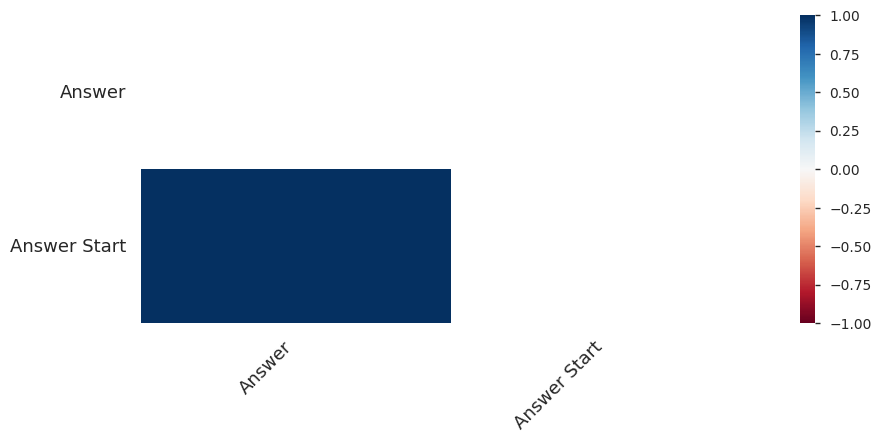

In [29]:
display(eda)